<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Homework2" data-toc-modified-id="Homework2-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Homework2</a></span></li></ul></li><li><span><a href="#Школа-GataScientist,-декабрь-2022,-Андреева-Ольга" data-toc-modified-id="Школа-GataScientist,-декабрь-2022,-Андреева-Ольга-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Школа GataScientist, декабрь 2022, Андреева Ольга</a></span></li></ul></div>

## Homework2
# Школа GataScientist, декабрь 2022, Андреева Ольга

Собрать информацию о всех строящихся объектах на сайте "наш.дом.рф".
Cохранить ее в pandas dataframe

In [78]:
import requests
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

In [ ]:
#функция для получения общего количества id-шников
def getTotalCount():
    url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset=1&limit=1&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
    res = requests.get(url)
    return  res.json().get('data').get('total')

#функция для чтения пачки id-шников
def readIDs(p_offset, p_limit):
    c_http_success = 200
    url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={p_offset}&limit={p_limit}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
    res = requests.get(url)
    if res.status_code == c_http_success:
        try:
            objects_data = res.json()
            objects_list = objects_data.get('data').get('list')
            return {'state': c_http_success, 'data':[x.get('objId') for x in objects_list]}
        except IndexError:
            return({'state': c_http_success,'data': []});
    else:
        return({'state': res.status_code, 'data': []})
    
#функция для чтения объекта по id-шнику
def readObjectData (p_ObjID):
    # Для скачивания данных по определенному объекту, нужно добавить его id в конец строки запроса
    url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{p_ObjID}'
    res = requests.get(url)
    return res.json().get('data')    

In [ ]:
v_offset = 1
v_limit = 100
c_max_limit = getTotalCount() #getTotalCount() - если надо скачать ВСЕ записи
lst_Objects=[]
df_Objects=pd.DataFrame([])
c_http_success = 200

print ("must get: ", c_max_limit)

from datetime import datetime
import time
start_time = datetime.now()

while True:
    #обработка ограничения по количеству записей
    if v_offset + v_limit > c_max_limit:
        v_limit = c_max_limit - v_offset + 1
    
    v_IDs_bath = readIDs(v_offset, v_limit) #cчитали порцию id-шников
    
    if v_IDs_bath.get('state') != c_http_success:
        print (v_IDs_bath.get('state'), "на ", v_offset, "!")
    else:
        v_IDs=v_IDs_bath.get('data')
        print(v_offset, " - code ", v_IDs_bath.get('state'))
        #читаем каждый объект по ID
        lst_Objects=[]
        for i in (v_IDs):
            v_Object=readObjectData(i) 
            lst_Objects.append(v_Object)

        #добавляем пачку объектов в датафрейм
        df_Objects=df_Objects.append(pd.DataFrame(lst_Objects),ignore_index=True)     
 
    v_offset += v_limit
    print ("have got: ", v_offset-1)
    if len(v_IDs)<v_limit or v_offset>c_max_limit: break

print('Time: ', datetime.now() - start_time)
   
    

Cохранить pandas dataframe в excel

In [ ]:
df_Objects.head(5)

In [ ]:
df_Objects.to_excel("./df_Objects.xlsx")


In [119]:
#прочитали - забэкапили
df_Objects=pd.read_excel("./df_Objects.xlsx")
df_Objects_bkp=df_Objects.copy()

Проверить состояние датафрейма и привести его в формат, позволяющий дальнейшее исследование данных:
    -- Привести колонки датафрейма к одному типу данных
    -- Проверить индекс, чтобы он соответствовал порядку строк 
    -- Проверить наличие пропусков и в случае обнаружения, определить стратегию их обработки

In [120]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_Objects.dtypes)

address                          object
airQualityIndexValue            float64
complexShortNm                   object
conclusion                      float64
developer                        object
floorMax                          int64
floorMin                          int64
generalContractorNm              object
greenAreaIndexValue             float64
hobjId                            int64
id                                int64
infrastructureIndexValue        float64
isAvailableWantLiveHere            bool
loadDttm                         object
metro                            object
miniUrl                          object
nameObj                          object
newBuildingId                   float64
nonlivFirstFloor                float64
objCompensFundFlg                 int64
objElemLivingCnt                  int64
objElemParkingCnt                 int64
objElevatorCargoCnt             float64
objElevatorCargoPassengerCnt      int64
objElevatorPassengerCnt         float64


In [122]:
#удалили колонки, которые не понадобятся
df_Objects=df_Objects.drop(['rpdPdfLink','miniUrl', 'photoRenderDTO','quartography'], axis=1)

In [123]:
#преобразование типов
df_Objects['developer']=df_Objects['developer'].apply(eval)
df_Objects['objectTransportInfo']=df_Objects['objectTransportInfo'].apply(eval)
df_Objects['objReady100PercDt']=pd.to_datetime(df_Objects['objReady100PercDt'], format="%Y-%m-%d")
df_Objects['objTransferPlanDt']=pd.to_datetime(df_Objects['objTransferPlanDt'], format="%d-%m-%Y %H:%M")
df_Objects['rpdIssueDttm']=pd.to_datetime(df_Objects['rpdIssueDttm'], format="%d-%m-%Y %H:%M")

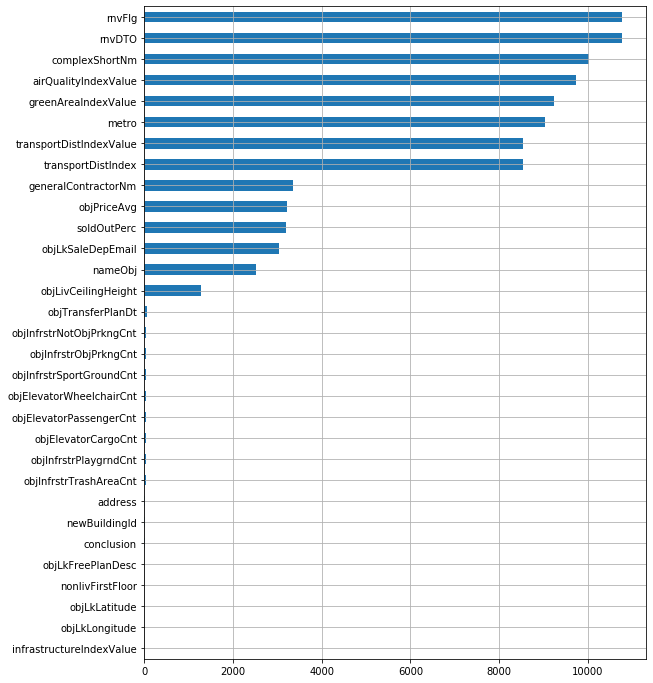

In [124]:
# Посмотрим, что у нас по пропущенным данным
s_Missing=pd.Series([])
for clmn in df_Objects.columns:
    is_empty = df_Objects[clmn].isnull()
    empty_cnt = np.sum(is_empty)
    s_Missing[clmn] = empty_cnt
# визуализируем
from pylab import rcParams
rcParams['figure.figsize'] = 9,12
s_Missing[s_Missing>0].sort_values(ascending=True).plot(kind='barh')
plt.grid(True)
plt.show()


In [127]:
#удалим колонки, ктотрые не заполнеы более чем на 60%
for clmn in s_Missing[s_Missing>len(df_Objects.index)/2].index:
    df_Objects=df_Objects.drop([clmn], axis=1)

In [129]:
df_Objects.head(5)

,address,conclusion,developer,floorMax,floorMin,generalContractorNm,hobjId,id,infrastructureIndexValue,isAvailableWantLiveHere,...,objTransferPlanDt,objectTransportInfo,objectType,pdId,region,residentialBuildings,rpdIssueDttm,rpdNum,soldOutPerc,wallMaterialShortDesc
0,г Тюмень,0.0,"{'devId': 306, 'devShortCleanNm': '2МЕН ГРУПП'...",20,4,ООО Транспромжилстрой-2005 (ИНН: 7204097730),39024,13383,10.0,True,...,2023-02-28 12:00:00,[],normal,28105,72,1,2022-12-09 15:05:00,72-000095,0.406985,Другое
1,"г Тюмень, ул Профсоюзная, д. 56",0.0,"{'devId': 306, 'devShortCleanNm': '2МЕН ГРУПП'...",10,7,ООО Транспромжилстрой-2005 (ИНН: 7204097730),37165,13398,10.0,True,...,2025-02-28 12:00:00,[],normal,28141,72,1,2022-12-09 15:04:00,72-000097,1.000000,Другое
2,"г Тюмень, ул Профсоюзная, д. 56",0.0,"{'devId': 306, 'devShortCleanNm': '2МЕН ГРУПП'...",12,6,ООО Транспромжилстрой-2005 (ИНН: 7204097730),37201,13397,10.0,True,...,2025-02-28 12:00:00,[],normal,28141,72,1,2022-12-09 15:04:00,72-000097,0.999984,Другое
3,"г Тюмень, ул Профсоюзная, д. 56",0.0,"{'devId': 306, 'devShortCleanNm': '2МЕН ГРУПП'...",1,1,ООО Транспромжилстрой-2005 (ИНН: 7204097730),34754,13399,10.0,True,...,2025-02-28 12:00:00,[],normal,28141,72,0,2022-12-09 15:04:00,72-000097,0.917243,Другое
4,"г Ставрополь, ул Шпаковская, Доваторцев, д. 10...",0.0,"{'devId': 10296, 'devShortCleanNm': 'CЗ СТРОЙР...",10,2,ООО Стройресурс (ИНН: 2634053119),117248,36912,8.0,True,...,2022-12-31 12:00:00,[],normal,337586,26,1,2022-12-02 12:57:00,26-000567,0.609216,Монолит-кирпич
